In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv("/content/household_power_consumption.txt", sep=';')
data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
data.set_index('Datetime', inplace=True)
data.drop(['Date', 'Time'], axis=1, inplace=True)
data.replace('?', np.nan, inplace=True) # Replace '?' with NaN
data.fillna(method='ffill', inplace=True) # Fill NaN values using forward fill

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])  # Predicting 'Global_active_power'
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and test sets
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Build LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(seq_length, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))




<ipython-input-1-31a531d6aa03>:11: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data['Datetime'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])


Epoch 1/50
3652/3652 [==============================] - 56s 13ms/step - loss: 0.0019 - val_loss: 8.5625e-04
Epoch 2/50
3652/3652 [==============================] - 47s 13ms/step - loss: 0.0013 - val_loss: 8.0112e-04
Epoch 3/50
3652/3652 [==============================] - 47s 13ms/step - loss: 0.0013 - val_loss: 7.9379e-04
Epoch 4/50
3652/3652 [==============================] - 47s 13ms/step - loss: 0.0012 - val_loss: 7.7939e-04
Epoch 5/50
3652/3652 [==============================] - 49s 13ms/step - loss: 0.0012 - val_loss: 8.1609e-04
Epoch 6/50
3652/3652 [==============================] - 48s 13ms/step - loss: 0.0011 - val_loss: 7.8440e-04
Epoch 7/50
3652/3652 [==============================] - 49s 14ms/step - loss: 0.0011 - val_loss: 7.4298e-04
Epoch 8/50
3652/3652 [==============================] - 49s 13ms/step - loss: 0.0010 - val_loss: 7.3095e-04
Epoch 9/50
3652/3652 [==============================] - 51s 14ms/step - loss: 0.0010 - val_loss: 7.6880e-04
Epoch 10/50
3652/3652 [=====

913/913 [==============================] - 5s 5ms/step


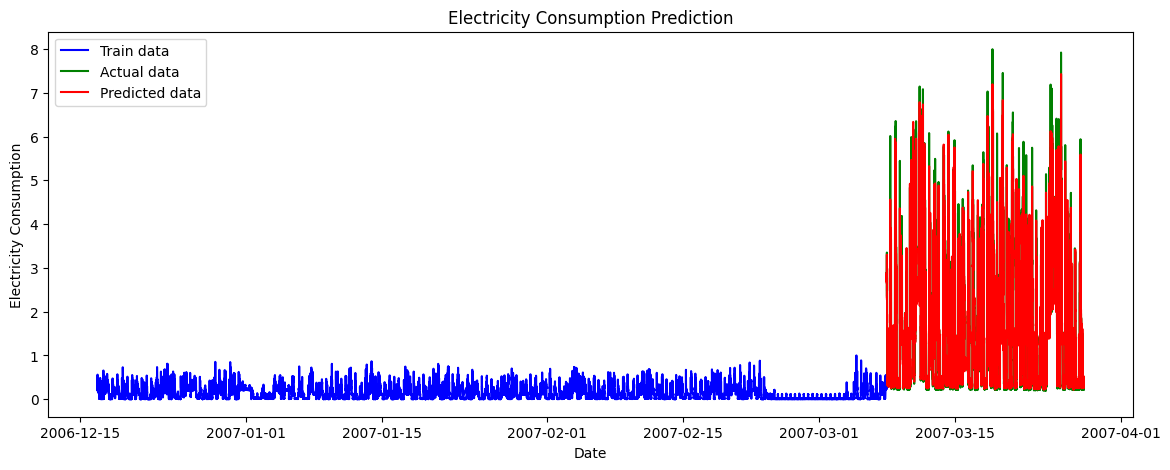

In [ ]:
# Evaluate model
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)
predictions = scaler.inverse_transform(np.hstack([predictions, np.zeros((predictions.shape[0], data.shape[1]-1))]))[:, 0] # Inverse transform considering all features
# Reshape y_test to have the same number of features as the original data before inverse transforming
y_test_reshaped = y_test.reshape(-1, 1)
y_test_reshaped = np.hstack([y_test_reshaped, np.zeros((y_test_reshaped.shape[0], data.shape[1]-1))])
y_test = scaler.inverse_transform(y_test_reshaped)[:, 0] # Do the same for y_test

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(14,5))
plt.plot(data.index[seq_length:split + seq_length], y_train, color='blue', label='Train data')
plt.plot(data.index[split + seq_length:], y_test, color='green', label='Actual data')
plt.plot(data.index[split + seq_length:], predictions, color='red', label='Predicted data')
plt.title('Electricity Consumption Prediction')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.legend()
plt.show()

In [ ]:
# Convert the NumPy array to a Pandas Series for using .head()
pd.Series(predictions).head()


0    2.769448
1    2.760442
2    2.765421
3    2.753326
4    2.772516
dtype: float64

In [ ]:

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

print(f'Mean Absolute Error (MAE): {mae:.3f}')
print(f'Mean Squared Error (MSE): {mse:.3f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.3f}')
print(f'R-squared (R²) Score: {r2:.3f}')


Mean Absolute Error (MAE): 0.112
Mean Squared Error (MSE): 0.069
Root Mean Squared Error (RMSE): 0.263
R-squared (R²) Score: 0.955
